<a href="https://colab.research.google.com/github/amsewr/planeclassification/blob/main/notebooks/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data & imports

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.0M      0  0:01:33  0:01:33 --:--:-- 29.2M


In [2]:
import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from tf.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from PIL import Image

# Constantes

In [3]:
DATA_DIR = pathlib.Path('dataset/data')

IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_DEPTH = 3

# Functions

In [4]:
manufacturer_df =pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

#split donne une chaine de caractères
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

#'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [6]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

In [7]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


In [5]:
def build_image_database(path) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  manufacturer_df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return manufacturer_df

In [9]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt')

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg
...,...,...,...,...
3329,1577680 Yakovlev,1577680,Yakovlev,dataset/data/images/1577680.jpg
3330,1826676 Yakovlev,1826676,Yakovlev,dataset/data/images/1826676.jpg
3331,0472681 Yakovlev,0472681,Yakovlev,dataset/data/images/0472681.jpg
3332,1597829 Yakovlev,1597829,Yakovlev,dataset/data/images/1597829.jpg


In [6]:
def build_image_database(path, target) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 
  target (str) : name of the target column.

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  _df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return _df.drop(columns=['all'])

In [11]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer').head()

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg


In [12]:
build_image_database(DATA_DIR / 'images_family_train.txt', 'family').head()

,image_id,family,path
0,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192,Boeing 707,dataset/data/images/1340192.jpg
2,0056978,Boeing 707,dataset/data/images/0056978.jpg
3,0698580,Boeing 707,dataset/data/images/0698580.jpg
4,0450014,Boeing 707,dataset/data/images/0450014.jpg


In [13]:
build_image_database(DATA_DIR / 'images_variant_train.txt', 'variant').head()

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg
2,0056978,707-320,dataset/data/images/0056978.jpg
3,0698580,707-320,dataset/data/images/0698580.jpg
4,0450014,707-320,dataset/data/images/0450014.jpg


# Load manufacturer_df

In [14]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [15]:
manufacturer_df.head()['path'].values[0]

PosixPath('dataset/data/images/1025794.jpg')

In [16]:
plt.imshow(plt.imread(manufacturer_df.head()['path'].values[0]))

FileNotFoundError: ignored

In [7]:
# La fonction :
# - prend un df (argument) 
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target) : 
  """Show an image from an image database, with the associated class

  Parameters
  -----------
  df(pd.DataFrame) : images definition dataframe
  row (int) :  row index in df of image to be displayed
  target (str) : name of the target column

  Returns
  ---------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))

  return

In [ ]:
show_image(build_image_database(DATA_DIR / 'images_family_train.txt', 'family'), 1515, 'family')

In [ ]:
show_image(manufacturer_df, 1930, 'manufacturer')

# Verify data

In [ ]:
# verif si "," dans le fichier
!grep ',' dataset/data/images_manufacturer_train.txt

In [ ]:
# rehcerche de T et affichage de 3 lignes
!grep 'T' dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [ ]:
# compter les éléments (ligne, caractère, word)
!grep 'T' dataset/data/images_manufacturer_train.txt | wc 

    132     264    1848


In [ ]:
# prendre une colonne
!cut -f 1 -d ' ' dataset/data/images_manufacturer_train.txt | head

1025794
1340192
0056978
0698580
0450014
1042824
0894380
1427680
0817494
0716386


In [ ]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

In [ ]:
manufacturer_df.isna().sum()

all             0
image_id        0
manufacturer    0
dtype: int64

In [ ]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Missing values in image_id"
assert manufacturer_df['manufacturer'].isna().sum() == 0, "Missing values in manufcaturer"

# Tenserflow

In [17]:
manufacturer_df.shape

(3334, 3)

In [18]:
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg


In [19]:
show_image(manufacturer_df, 0, 'manufacturer')

NameError: ignored

In [20]:
plt.imread(manufacturer_df.head(1)['path'].values[0]).shape

FileNotFoundError: ignored

In [ ]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de colonnes
manufacturer_df['shape'].apply(lambda x: x[1]).value_counts()

In [8]:
images_list = []
def load_resize_image(path,width, height):
  """Load an image and resize it to the target size
  
  Parameters 
  ----------

  path (Path):access path to image file
  height (int):resize image to this height 
  width (int):resize image to this width 

  Returns
  -------
  np.array containing resized image
  
  """
  return np.array(Image.open(path).resize((width, height)))

In [22]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_WIDTH, IMAGE_HEIGHT), axis=1)

FileNotFoundError: ignored

In [ ]:
plt.imshow(manufacturer_df.iloc[0,]['resized_image'])

In [ ]:
# Calcul du nombre de classes pour dimensionner la couche de sortie
nb_classes = manufacturer_df['manufacturer'].nunique()

In [ ]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape= (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_DEPTH)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
manufacturer_df['manufacturer'].astype('category').cat.codes

In [ ]:
y = tf.keras.utils.to_categorical(manufacturer_df['manufacturer'].astype('category').cat.codes)

In [9]:
def build_classification_model(df, target, images):
  """Build a TF model using information from target and images columns in dataframe. 

  Parameters
  ----------
  df (pd.DataFrame) : dataframe with target and images columns
  target (str) : column name for target variable
  images (str) : column name for images

  Returns
  -------
  TF model built a compiled
  """
  nb_classes = df[target].nunique() # compute number of classes for output layer
  size = df[images].iloc[0].shape # compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape= size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax'))

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
model = build_classification_model(manufacturer_df, 'manufacturer', 'resized_image')

# Build train & test set

In [35]:
X_train, X_test, y_train, y_test = train_test_split(manufacturer_df[['resized_image','manufacturer']], y, 
                                                    test_size=0.2, 
                                                    stratify=manufacturer_df['manufacturer'])

In [44]:
assert X_train.shape[0] + X_test.shape[0] == manufacturer_df.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

In [ ]:
X_train['manufacturer'].value_counts(normalize=True)

In [39]:
%%time
epochs = 5
history = model.fit(np.array(X_train['resized_image'].to_list()), y_train, batch_size=32, epochs=epochs,
                    validation_data=(np.array(X_test['resized_image'].to_list()), y_test))

Epoch 1/5
84/84 [==============================] - 294s 3s/step - loss: 27.1551 - accuracy: 0.1672 - val_loss: 3.3477 - val_accuracy: 0.2204
Epoch 2/5
84/84 [==============================] - 291s 3s/step - loss: 3.0117 - accuracy: 0.2122 - val_loss: 3.2640 - val_accuracy: 0.2204
Epoch 3/5
84/84 [==============================] - 292s 3s/step - loss: 2.9430 - accuracy: 0.2085 - val_loss: 3.1685 - val_accuracy: 0.2219
Epoch 4/5
84/84 [==============================] - 293s 3s/step - loss: 2.8433 - accuracy: 0.2103 - val_loss: 2.9126 - val_accuracy: 0.2204
Epoch 5/5
84/84 [==============================] - 290s 3s/step - loss: 2.6812 - accuracy: 0.2265 - val_loss: 2.7894 - val_accuracy: 0.2249
CPU times: user 46min 49s, sys: 25 s, total: 47min 14s
Wall time: 24min 23s


In [10]:
def build_x_and_y(df : pd.DataFrame, target : str, images : str):
  """Build x tensor and y tensor for model fitting. 

  Parameters
  -----------
  df (pd.DataFrame) : dataframe containing images and target 
  target (str) : name of target column
  images (str) : name of images column

  Returns
  ---------
  x (np.array) : tensor for x values 
  y (np.array) : tensor for y valuess
  """

  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y


In [11]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')
test_df = build_image_database(DATA_DIR / 'images_manufacturer_test.txt', 'manufacturer')

# Load & resize images
train_df['resized_images'] = train_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)
test_df['resized_images'] = test_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, 'manufacturer', 'resized_images')
X_test, y_test = build_x_and_y(test_df, 'manufacturer', 'resized_images')

# Build TF classification model
model = build_classification_model(train_df, 'manufacturer', 'resized_images')

In [12]:
X_train.shape

(3334, 128, 128, 3)

In [13]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.122.224.122:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.224.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.224.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [23]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, 'manufacturer', 'resized_images')

In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs,
                    validation_data=(X_test, y_test))

In [28]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs,
                    validation_data=(X_test, y_test))

In [32]:
test_df['resized_images'].iloc[0].shape

(128, 128, 3)

In [37]:
np.argmax(model.predict(X_test[10:21]),axis=1)

array([ 4,  4, 13,  1,  4,  4,  1,  4,  4,  1,  4])

Boeing


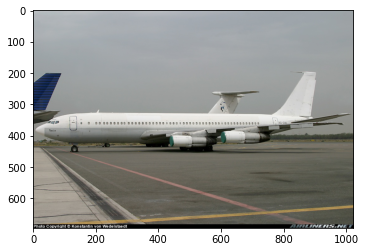

In [35]:
show_image(test_df, 10, 'manufacturer')

In [42]:
train_df['manufacturer'].astype('category').cat.categories

Index(['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland'],
      dtype='object')

In [46]:
def classify_images(images, model,classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names : dictionary with names of classes

  Returns
  --------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax is computed row by row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

In [40]:
classify_images(X_test, model, )

(3333,)

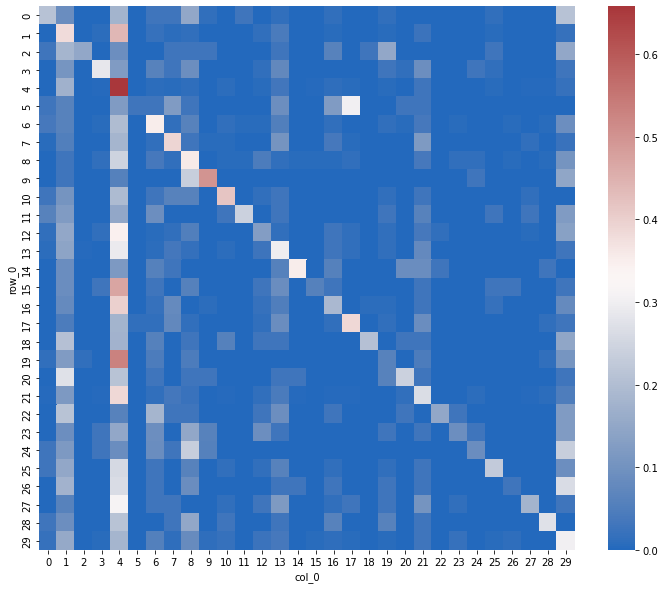

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1), classify_images(X_test, model), normalize='index'), cmap='vlag',ax=ax)

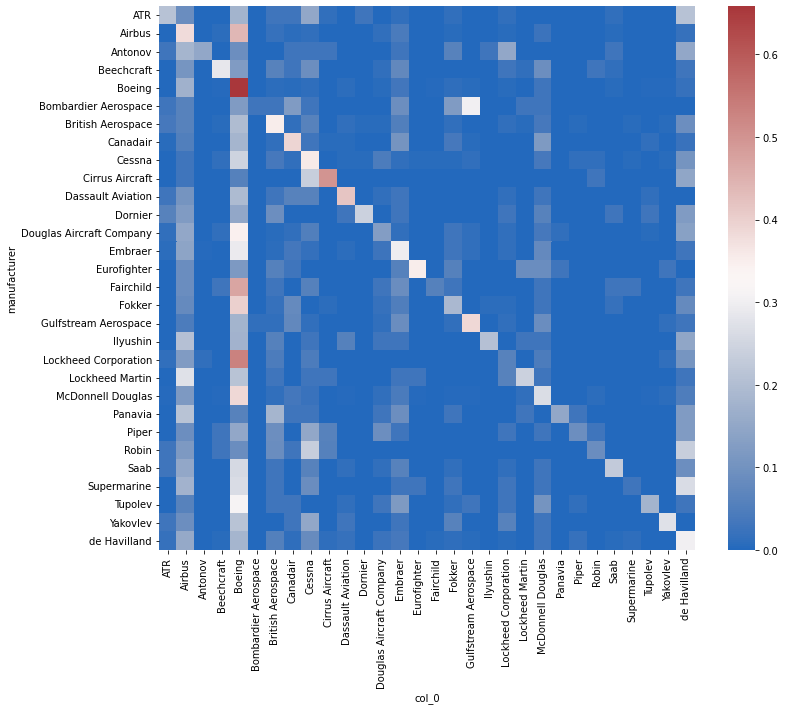

In [50]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df['manufacturer'], classify_images(X_test, model,test_df['manufacturer'].astype('category').cat.categories), 
                        normalize='index'), cmap='vlag',ax=ax)

In [51]:
model.save('model/my_model.h5')

In [53]:
!ls -lh model

total 149M
-rw-r--r-- 1 root root 149M Mar 18 16:22 my_model.h5


In [55]:
import datetime

def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return

In [56]:
save_model(model,'model/planes')

In [57]:
reloaded_model = load_model('/content/model/planes_2022-03-18_16-27-40.h5')

In [59]:
np.argmax(reloaded_model.predict(X_test[10:20]), axis=1)

array([ 4,  4, 13,  1,  4,  4,  1,  4,  4,  1])